In [302]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso, Ridge, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

### Ridge Model - Predicting Reports

In [303]:
hikes = pd.read_csv('../data/wta-parks-data.csv', sep='\t', index_col=0)
hikes_model = hikes.drop(columns=['description','url','name','pass: None','votes', 'lat','lon','drive distance']).dropna()
# hikes_model = hikes[['reports','length','gain','drive time','technical','pass: None']].dropna()

## Model on Reports feature

In [304]:
X = hikes_model.drop(columns=['reports','rating']).values
y = hikes_model['reports'].values
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [305]:
model = sm.OLS(hikes_model['reports'], hikes_model.drop(columns=['reports','rating'])).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                reports   R-squared (uncentered):                   0.395
Model:                            OLS   Adj. R-squared (uncentered):              0.383
Method:                 Least Squares   F-statistic:                              34.02
Date:                Thu, 14 May 2020   Prob (F-statistic):                   2.70e-123
Time:                        12:13:39   Log-Likelihood:                         -8797.0
No. Observations:                1330   AIC:                                  1.764e+04
Df Residuals:                    1305   BIC:                                  1.777e+04
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
length                         -2.5306      0.684     -3.700      0.000      -3.872      -1.189
highest point                   0.0026      0.003      0.919      0.358      -0.003       0.008
gain                            0.0166      0.005      3.169      0.002       0.006       0.027
pass: Discover Pass           -12.1523     18.437     -0.659      0.510     -48.322      24.017
pass: National Monument Fee   157.6036    130.164      1.211      0.226     -97.750     412.957
pass: National Park Pass       -8.1689     20.646     -0.396      0.692     -48.672      32.335
pass: Northwest Forest Pass    44.2028     12.500      3.536      0.000      19.681      68.725
pass: Sno-Parks Permit        -52.6537     37.915     -1.389      0.165    -127.035      21.727
pass: Wilderness Permit       -79.4980    183.826     -0.432      0.665    -440.125     281.129
Wildflowers/Meadows            20.4010     11.795      1.730      0.084      -2.739      43.541
Dogs allowed on leash          14.0731     12.154      1.158      0.247      -9.771      37.917
Good for kids                  44.0796     12.850      3.430      0.001      18.871      69.289
Lakes                          49.0096     12.164      4.029      0.000      25.147      72.872
Fall foliage                   21.3554     14.909      1.432      0.152      -7.892      50.603
Coast                          39.6841     26.640      1.490      0.137     -12.578      91.946
Mountain views                 46.7921     12.455      3.757      0.000      22.357      71.227
Wildlife                      -12.1101     11.844     -1.022      0.307     -35.346      11.126
Old growth                     21.0239     12.538      1.677      0.094      -3.573      45.620
Summits                        35.6294     14.988      2.377      0.018       6.226      65.032
Ridges/passes                  -7.3388     14.244     -0.515      0.606     -35.282      20.604
Established campsites          30.2489     14.089      2.147      0.032       2.609      57.889
Waterfalls                    134.2133     16.409      8.179      0.000     102.022     166.405
Rivers                         12.3975     12.536      0.989      0.323     -12.195      36.990
drive time                     -0.0765      0.026     -2.954      0.003      -0.127      -0.026
technical                      -5.7098     27.319     -0.209      0.834     -59.303      47.883
==============================================================================
Omnibus:                     1215.556   Durbin-Watson:                   1.607
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            52066.256
Skew:                           4.166   Prob(JB):          

In [306]:
nalphas = 50
min_alpha_exp = 1
max_alpha_exp = 6
nfeatures = X.shape[1]
coefs = np.zeros((nalphas, nfeatures))
alphas = np.logspace(min_alpha_exp, max_alpha_exp, nalphas)
mse_train = np.zeros(nalphas)
mse_test = np.zeros(nalphas)
for idx, alpha in enumerate(alphas):
    model = Pipeline([('standardize', StandardScaler()),
                     ('ridge', RidgeCV(alphas=[alpha], cv=10))])
    model.fit(X_train, y_train)
    coefs[idx] = model.steps[1][1].coef_
    mse_train[idx] = mean_squared_error(y_train, model.predict(X_train))
    mse_test[idx] = mean_squared_error(y_test, model.predict(X_test))

nalphas = 50
min_alpha_exp = 1
max_alpha_exp = 6
nfeatures = X.shape[1]
coefs = np.zeros((nalphas, nfeatures))
alphas = np.logspace(min_alpha_exp, max_alpha_exp, nalphas)
mse_train = np.zeros(nalphas)
mse_test = np.zeros(nalphas)
x_scaler = StandardScaler()
y_scaler = StandardScaler()
x_scaler.fit(X_train)
y_scaler.fit(y_train.reshape(-1,1))
X_train_scaled = x_scaler.transform(X_train)
X_test_scaled = x_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train.reshape(-1,1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1,1))

for idx, alpha in enumerate(alphas):
    model = RidgeCV(alphas=[alpha], cv=10)
    model.fit(X_train_scaled, y_train_scaled)
    coefs[idx] = model.coef_
    y_pred_train = y_scaler.inverse_transform(model.predict(X_train_scaled))
    y_pred_test = y_scaler.inverse_transform(model.predict(X_test_scaled))
    mse_train[idx] = mean_squared_error(y_train, y_pred_train)
    mse_test[idx] = mean_squared_error(y_test, y_pred_test)

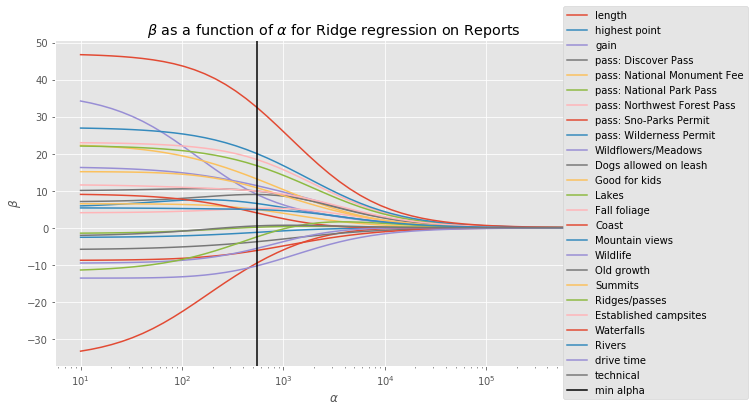

In [307]:
fig, ax = plt.subplots(figsize=(10,6))
for feature in range(nfeatures):
    ax.plot(alphas, coefs[:, feature],
             label=columns[feature])

ax.axvline(alphas[(np.argmin(mse_test))], label='min alpha', color='k')
ax.set_xscale('log')
ax.set_title("$\\beta$ as a function of $\\alpha$ for Ridge Regression on Reports")
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$\\beta$")
ax.legend(loc="right", bbox_to_anchor=(1.25, .5), framealpha=1)
fig.savefig('../images/reports_ridge_beta_vs_alpha.png', bbox_inches='tight', dpi=350)

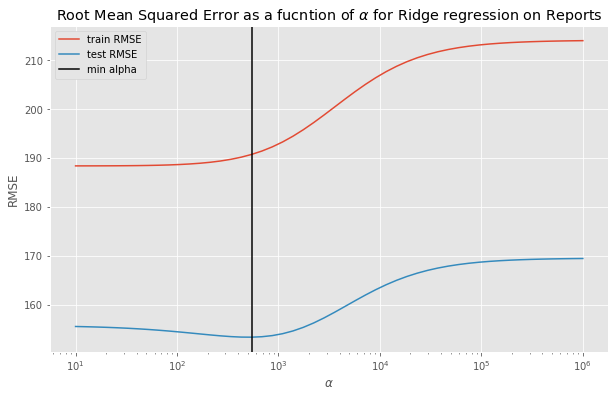

In [308]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(alphas, np.sqrt(mse_train), label='train RMSE')
ax.plot(alphas, np.sqrt(mse_test), label='test RMSE')
ax.axvline(alphas[(np.argmin(mse_test))], label='min alpha', color='k')
ax.set_xscale('log')
ax.set_title('Root Mean Squared Error as a fucntion of $\\alpha$ for Ridge Regression on Reports')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("RMSE")
ax.legend(loc='best', framealpha=1)
fig.savefig('../images/reports_ridge_rmse.png', bbox_inches='tight', dpi=350)

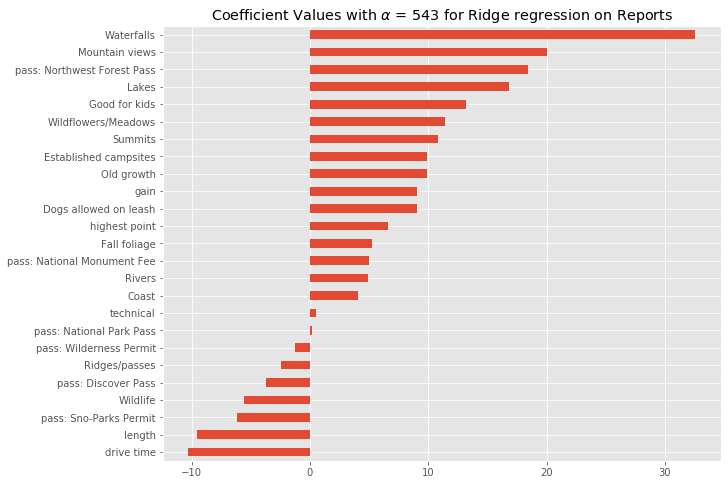

In [309]:
min_alpha = alphas[(np.argmin(mse_test))]
model = Pipeline([('standardize', StandardScaler()),
                     ('ridge', RidgeCV(alphas=[min_alpha], cv=10))])
model.fit(X_train, y_train)
ridge_coefs = model.steps[1][1].coef_

ridge_coefs = pd.DataFrame({'Coefficients': model.steps[1][1].coef_}, 
                       index=columns)

ridge_coefs = ridge_coefs.sort_values(by='Coefficients')
ridge_coefs.plot(kind='barh', figsize=(10,8), legend=False)
plt.title("Coefficient Values with $\\alpha$ = %.0f for Ridge Regression on Reports" % min_alpha)
plt.savefig("../images/reports_ridge_coefs_bar.png", bbox_inches='tight', dpi=350)

In [310]:
feat = 'reports'
print(f"The average {feat} value is {np.mean(hikes_model[feat]):.2f}.")
print(f"The standard deviation of the {feat} value is {np.std(hikes_model[feat]):.2f}.")
print(f"The model RMSE predicting the {feat} value is {np.sqrt(mean_squared_error(y_test, model.predict(X_test))):.2f}.")

The average reports value is 110.61.
The standard deviation of the reports value is 203.82.
The model RMSE predicting the reports value is 153.33.


## Model on Rating feature

In [318]:
X = hikes_model.drop(columns=['reports','rating']).values
y = hikes_model['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y)
columns = hikes_model.drop(columns=['reports','rating']).columns

In [319]:
model = sm.OLS(hikes_model['rating'], hikes_model.drop(columns=['reports','rating'])).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 rating   R-squared (uncentered):                   0.841
Model:                            OLS   Adj. R-squared (uncentered):              0.838
Method:                 Least Squares   F-statistic:                              276.0
Date:                Thu, 14 May 2020   Prob (F-statistic):                        0.00
Time:                        12:14:52   Log-Likelihood:                         -2297.4
No. Observations:                1330   AIC:                                      4645.
Df Residuals:                    1305   BIC:                                      4775.
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
length                         -0.0068      0.005     -1.316      0.189      -0.017       0.003
highest point                   0.0004   2.16e-05     19.030      0.000       0.000       0.000
gain                         4.408e-05   3.94e-05      1.118      0.264   -3.33e-05       0.000
pass: Discover Pass             0.6403      0.139      4.603      0.000       0.367       0.913
pass: National Monument Fee     0.0974      0.982      0.099      0.921      -1.829       2.024
pass: National Park Pass        0.2422      0.156      1.555      0.120      -0.063       0.548
pass: Northwest Forest Pass     0.1432      0.094      1.519      0.129      -0.042       0.328
pass: Sno-Parks Permit         -0.2988      0.286     -1.045      0.296      -0.860       0.262
pass: Wilderness Permit        -0.1061      1.387     -0.077      0.939      -2.827       2.615
Wildflowers/Meadows             0.2393      0.089      2.689      0.007       0.065       0.414
Dogs allowed on leash           0.1298      0.092      1.415      0.157      -0.050       0.310
Good for kids                   0.9019      0.097      9.303      0.000       0.712       1.092
Lakes                           0.3407      0.092      3.713      0.000       0.161       0.521
Fall foliage                   -0.0167      0.112     -0.149      0.882      -0.237       0.204
Coast                           1.7666      0.201      8.790      0.000       1.372       2.161
Mountain views                  0.2181      0.094      2.321      0.020       0.034       0.402
Wildlife                        0.2309      0.089      2.584      0.010       0.056       0.406
Old growth                      0.3401      0.095      3.596      0.000       0.155       0.526
Summits                         0.1096      0.113      0.969      0.333      -0.112       0.331
Ridges/passes                  -0.1032      0.107     -0.960      0.337      -0.314       0.108
Established campsites          -0.1050      0.106     -0.988      0.323      -0.314       0.103
Waterfalls                      0.5784      0.124      4.672      0.000       0.336       0.821
Rivers                          0.5532      0.095      5.850      0.000       0.368       0.739
drive time                      0.0008      0.000      3.965      0.000       0.000       0.001
technical                      -0.6192      0.206     -3.004      0.003      -1.024      -0.215
==============================================================================
Omnibus:                       53.026   Durbin-Watson:                   1.791
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.411
Skew:                          -0.394   Prob(JB):          

In [320]:
nalphas = 50
min_alpha_exp = 1
max_alpha_exp = 6
nfeatures = X.shape[1]
coefs = np.zeros((nalphas, nfeatures))
alphas = np.logspace(min_alpha_exp, max_alpha_exp, nalphas)
mse_train = np.zeros(nalphas)
mse_test = np.zeros(nalphas)
for idx, alpha in enumerate(alphas):
    model = Pipeline([('standardize', StandardScaler()),
                     ('ridge', RidgeCV(alphas=[alpha], cv=10))])
    model.fit(X_train, y_train)
    coefs[idx] = model.steps[1][1].coef_
    mse_train[idx] = mean_squared_error(y_train, model.predict(X_train))
    mse_test[idx] = mean_squared_error(y_test, model.predict(X_test))

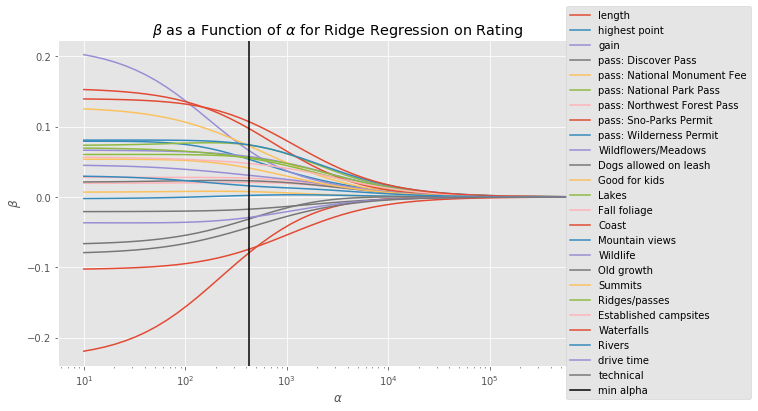

In [321]:
fig, ax = plt.subplots(figsize=(10,6))
for feature in range(nfeatures):
    ax.plot(alphas, coefs[:, feature],
             label=columns[feature])

ax.axvline(alphas[(np.argmin(mse_test))], label='min alpha', color='k')
ax.set_xscale('log')
ax.set_title("$\\beta$ as a Function of $\\alpha$ for Ridge Regression on Rating")
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$\\beta$")
ax.legend(loc="right", bbox_to_anchor=(1.25, .5), framealpha=1)
fig.savefig('../images/rating_ridge_beta_vs_alpha.png', bbox_inches='tight', dpi=350)

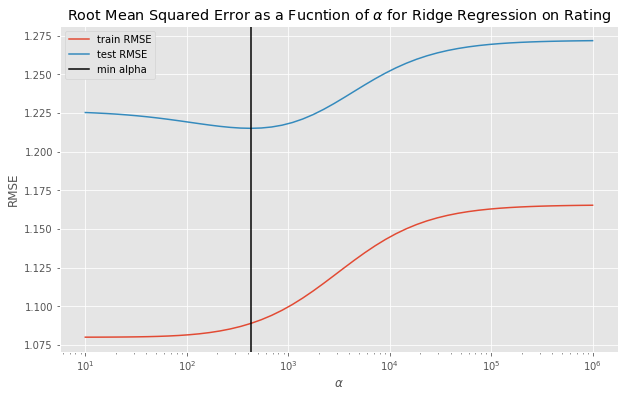

In [322]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(alphas, np.sqrt(mse_train), label='train RMSE')
ax.plot(alphas, np.sqrt(mse_test), label='test RMSE')
ax.axvline(alphas[(np.argmin(mse_test))], label='min alpha', color='k')
ax.set_xscale('log')
ax.set_title('Root Mean Squared Error as a Fucntion of $\\alpha$ for Ridge Regression on Rating')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("RMSE")
ax.legend(loc='best', framealpha=1)
fig.savefig('../images/rating_ridge_rmse.png', bbox_inches='tight', dpi=350)

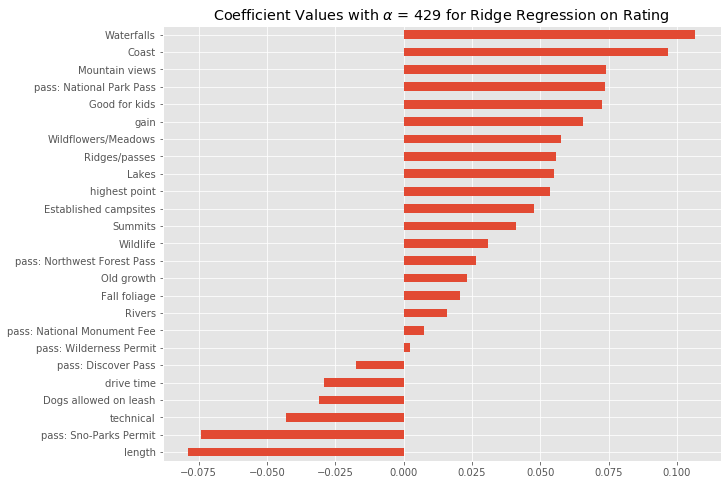

In [323]:
min_alpha = alphas[(np.argmin(mse_test))]
model = Pipeline([('standardize', StandardScaler()),
                     ('ridge', RidgeCV(alphas=[min_alpha], cv=10))])
model.fit(X_train, y_train)
ridge_coefs = model.steps[1][1].coef_

ridge_coefs = pd.DataFrame({'Coefficients': model.steps[1][1].coef_}, 
                       index=columns)

ridge_coefs = ridge_coefs.sort_values(by='Coefficients')
ridge_coefs.plot(kind='barh', figsize=(10,8), legend=False)
plt.title("Coefficient Values with $\\alpha$ = %.0f for Ridge Regression on Rating" % min_alpha)
plt.savefig("../images/rating_ridge_coefs_bar.png", bbox_inches='tight', dpi=350)

In [324]:
feat = 'rating'
print(f"The average {feat} value is {np.mean(hikes_model[feat]):.2f}.")
print(f"The standard deviation of the {feat} value is {np.std(hikes_model[feat]):.2f}.")
print(f"The model RMSE predicting the {feat} value is {np.sqrt(mean_squared_error(y_test, model.predict(X_test))):.2f}.")

The average rating value is 3.20.
The standard deviation of the rating value is 1.19.
The model RMSE predicting the rating value is 1.22.


## Statsmodels Results Table

In [364]:
reports_model = sm.OLS(hikes_model['reports'], hikes_model.drop(columns=['reports','rating'])).fit()
summary = reports_model.summary()
reports_sum_df = pd.DataFrame(summary.tables[1]).drop(index=0).iloc[:,[0,1,4]].rename(columns={0:'feature',1:'reports coef',4:'reports p-value'})

In [365]:
rating_model = sm.OLS(hikes_model['rating'], hikes_model.drop(columns=['reports','rating'])).fit()
summary = rating_model.summary()
rating_sum_df = pd.DataFrame(summary.tables[1]).drop(index=0).iloc[:,[1,4]].rename(columns={1:'rating coef',4:'rating p-value'})

In [367]:
sum_df = pd.concat([reports_sum_df, rating_sum_df], axis=1)

In [368]:
sum_df

,feature,reports coef,reports p-value,rating coef,rating p-value
1,length,-2.5306,0.000,-0.0068,0.189
2,highest point,0.0026,0.358,0.0004,0.000
3,gain,0.0166,0.002,4.408e-05,0.264
4,pass: Discover Pass,-12.1523,0.510,0.6403,0.000
5,pass: National Monument Fee,157.6036,0.226,0.0974,0.921
6,pass: National Park Pass,-8.1689,0.692,0.2422,0.120
7,pass: Northwest Forest Pass,44.2028,0.000,0.1432,0.129
8,pass: Sno-Parks Permit,-52.6537,0.165,-0.2988,0.296
9,pass: Wilderness Permit,-79.4980,0.665,-0.1061,0.939
10,Wildflowers/Meadows,20.4010,0.084,0.2393,0.007
